In [5]:
import numpy as np
import pandas as pd
from math import log
from scipy.stats import binom
from bitarray import bitarray
from bitarray.util import count_xor, zeros
from numpy.random import randint
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("ticks")
# scale plots
sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

In [6]:
rfmix_path = "/home/kmt/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)
#mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

In [7]:
meta_data_samples_sci = pd.read_csv("/home/kmt/baboondiversity/people/eriks/second_analysis_baboons/data/Papio_metadata_with_clustering_sci.txt", sep =" ")

window_df_eth["Origin"] = window_df_eth.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin+"_eth_case")))
window_df_eth["Sex"] = window_df_eth.individual.map(dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Sex)))

window_df_eth = window_df_eth.loc[(window_df_eth.Origin == 'Gog Woreda, Gambella region, Ethiopia_eth_case') \
    # & (window_df_eth.chrom == 'chr8')]
    & (window_df_eth.chrom == 'all_chrX')]
window_df_eth.head()

,chrom,individual,haplotype,start,end,north_sum,Origin,Sex
40236,all_chrX,PD_0720,0,0,100000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M
40237,all_chrX,PD_0720,0,100000,200000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M
40238,all_chrX,PD_0720,0,200000,300000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M
40239,all_chrX,PD_0720,0,300000,400000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M
40240,all_chrX,PD_0720,0,400000,500000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M


In [8]:
window_df_eth.Sex.value_counts()

Sex
M    48858
F    22992
Name: count, dtype: int64

In [9]:
df = window_df_eth.groupby(["start"]).north_sum.mean().reset_index()
window_df_eth = window_df_eth.merge(df, on='start', how='left', suffixes=('', '_window_mean'))

In [10]:
window_df_eth.head()

,chrom,individual,haplotype,start,end,north_sum,Origin,Sex,north_sum_window_mean
0,all_chrX,PD_0720,0,0,100000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M,0.0
1,all_chrX,PD_0720,0,100000,200000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M,0.0
2,all_chrX,PD_0720,0,200000,300000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M,0.0
3,all_chrX,PD_0720,0,300000,400000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M,0.0
4,all_chrX,PD_0720,0,400000,500000,0,"Gog Woreda, Gambella region, Ethiopia_eth_case",M,0.0


In [11]:
(window_df_eth.north_sum_window_mean / 100000)**2 

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
71845    0.0
71846    0.0
71847    0.0
71848    0.0
71849    0.0
Name: north_sum_window_mean, Length: 71850, dtype: float64

In [34]:
plot_df = window_df_eth.loc[
    (window_df_eth.Sex == 'F') & ((window_df_eth.north_sum == 100000) | (window_df_eth.north_sum == 0))
].groupby(["individual", "start", "end"])[['north_sum', 'north_sum_window_mean']].mean().reset_index()

In [35]:
plot_df.head()

,individual,start,end,north_sum,north_sum_window_mean
0,PD_0721,0,100000,0.0,0.0
1,PD_0721,100000,200000,0.0,0.0
2,PD_0721,200000,300000,0.0,0.0
3,PD_0721,300000,400000,0.0,0.0
4,PD_0721,400000,500000,0.0,0.0


In [36]:
plot_df['is_homo_hama'] = (plot_df.north_sum > 95000).astype(int)
plot_df['prob_homo_hama'] = (plot_df.north_sum_window_mean / 100000)**2
plot_df['is_homo_olive']= (plot_df.north_sum < 5000).astype(int)
plot_df['prob_homo_olive']= (1- plot_df.north_sum_window_mean / 100000)**2
plot_df.head()

,individual,start,end,north_sum,north_sum_window_mean,is_homo_hama,prob_homo_hama,is_homo_olive,prob_homo_olive
0,PD_0721,0,100000,0.0,0.0,0,0.0,1,1.0
1,PD_0721,100000,200000,0.0,0.0,0,0.0,1,1.0
2,PD_0721,200000,300000,0.0,0.0,0,0.0,1,1.0
3,PD_0721,300000,400000,0.0,0.0,0,0.0,1,1.0
4,PD_0721,400000,500000,0.0,0.0,0,0.0,1,1.0


In [37]:
plot_df['homo_hama_excess'] = (plot_df.is_homo_hama - plot_df.prob_homo_hama) 
plot_df['homo_olive_excess'] = (plot_df.is_homo_olive - plot_df.prob_homo_olive) 

plot_df.groupby('individual').mean()

,start,end,north_sum,north_sum_window_mean,is_homo_hama,prob_homo_hama,is_homo_olive,prob_homo_olive,homo_hama_excess,homo_olive_excess
individual,,,,,,,,,,
PD_0721,7.181784e+07,7.191784e+07,33688.699360,32741.555977,0.273632,0.231912,0.599858,0.577081,0.041720,0.022777
PD_0724,7.197270e+07,7.207270e+07,32822.523165,32371.520257,0.280827,0.229109,0.624376,0.581679,0.051718,0.042698
PD_0726,7.178061e+07,7.188061e+07,33510.261854,32599.714650,0.280962,0.230503,0.610757,0.578508,0.050460,0.032249
PD_0730,7.183479e+07,7.193479e+07,35107.142857,32541.437014,0.284286,0.230618,0.582143,0.579789,0.053668,0.002354
PD_0736,7.188416e+07,7.198416e+07,32544.802867,32242.589047,0.256631,0.228460,0.605735,0.583608,0.028171,0.022127
PD_0737,7.237835e+07,7.247835e+07,30702.389573,32342.476713,0.269370,0.229715,0.655322,0.582865,0.039655,0.072457
PD_0738,7.152602e+07,7.162602e+07,31863.799283,32501.914910,0.267384,0.230869,0.630108,0.580831,0.036515,0.049277
PD_0744,7.191875e+07,7.201875e+07,33321.403006,32489.802777,0.272727,0.230658,0.606299,0.580862,0.042069,0.025437


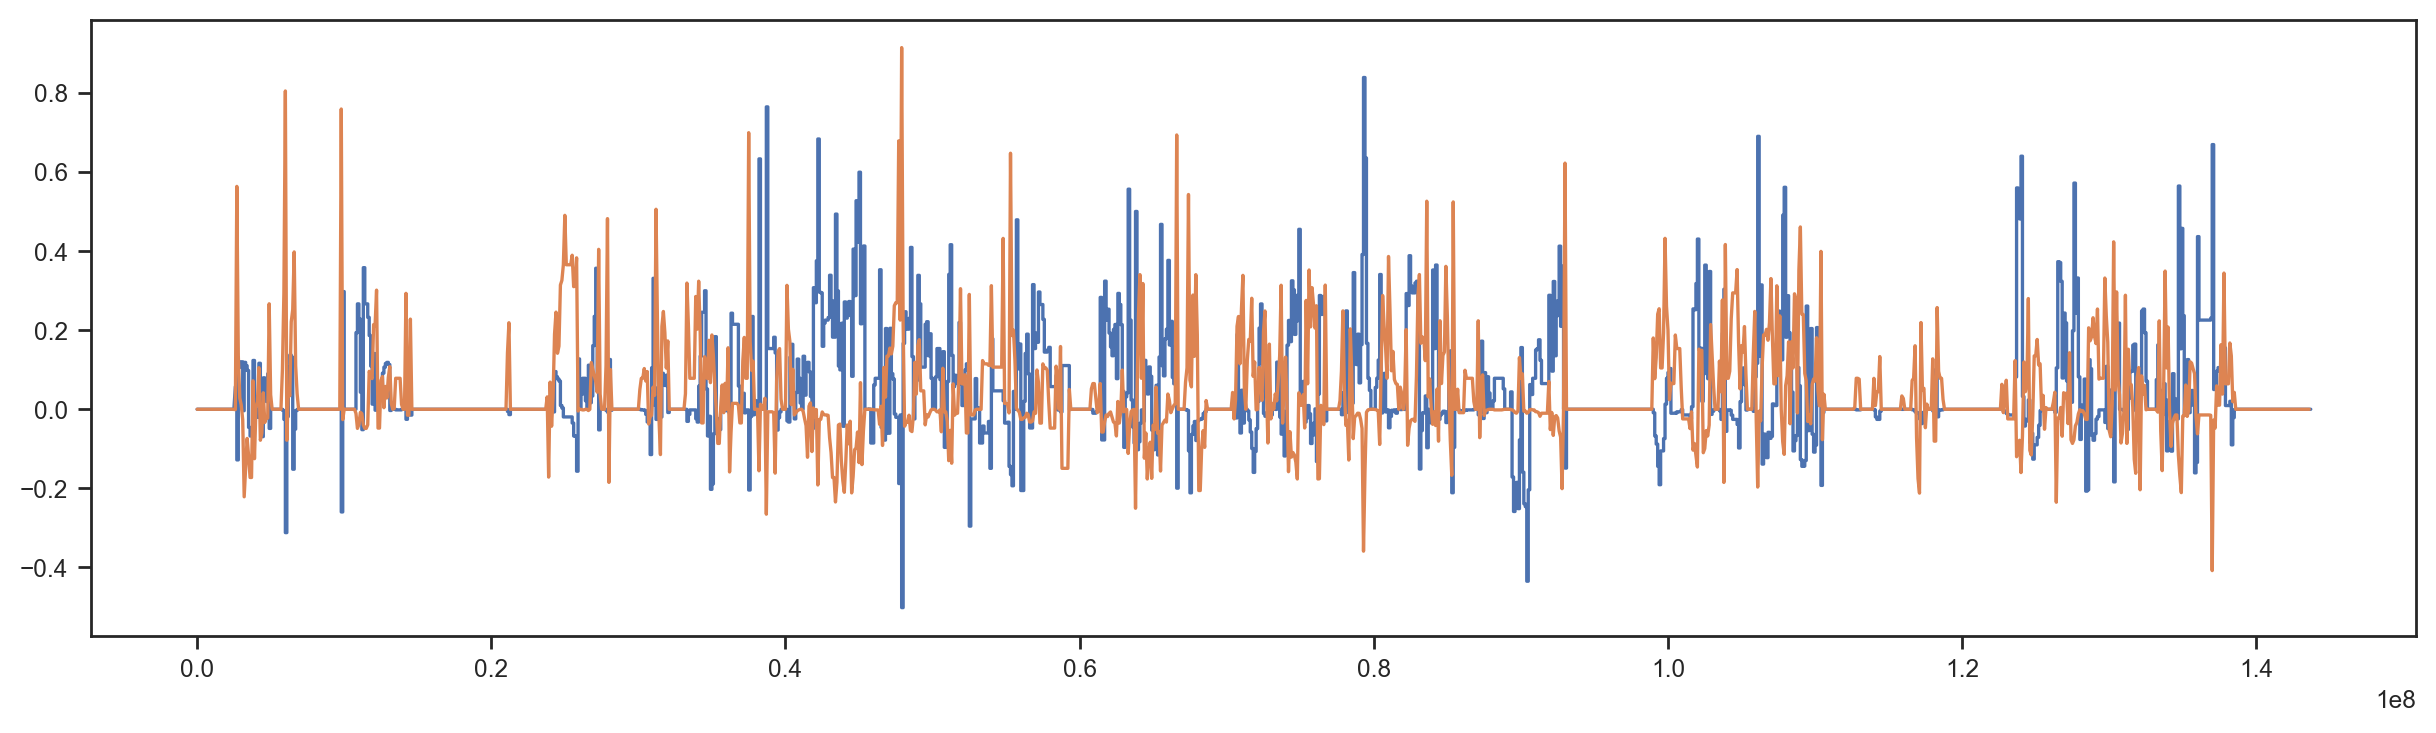

In [44]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])
    
# fig, ax = plt.subplots(2, 1, figsize=(15, 7))
fig, ax = plt.subplots(figsize=(15, 4))
_df = plot_df.groupby(['start', 'end'])[['is_homo_hama', 'prob_homo_hama', 'is_homo_olive', 
                                'prob_homo_olive', 'homo_hama_excess', 'homo_olive_excess']].mean().reset_index()
_df = stairs(_df)
ax.plot(_df.pos, _df.homo_hama_excess)
ax.plot(_df.start, _df.homo_olive_excess) ;

# Make geneinfo plots...

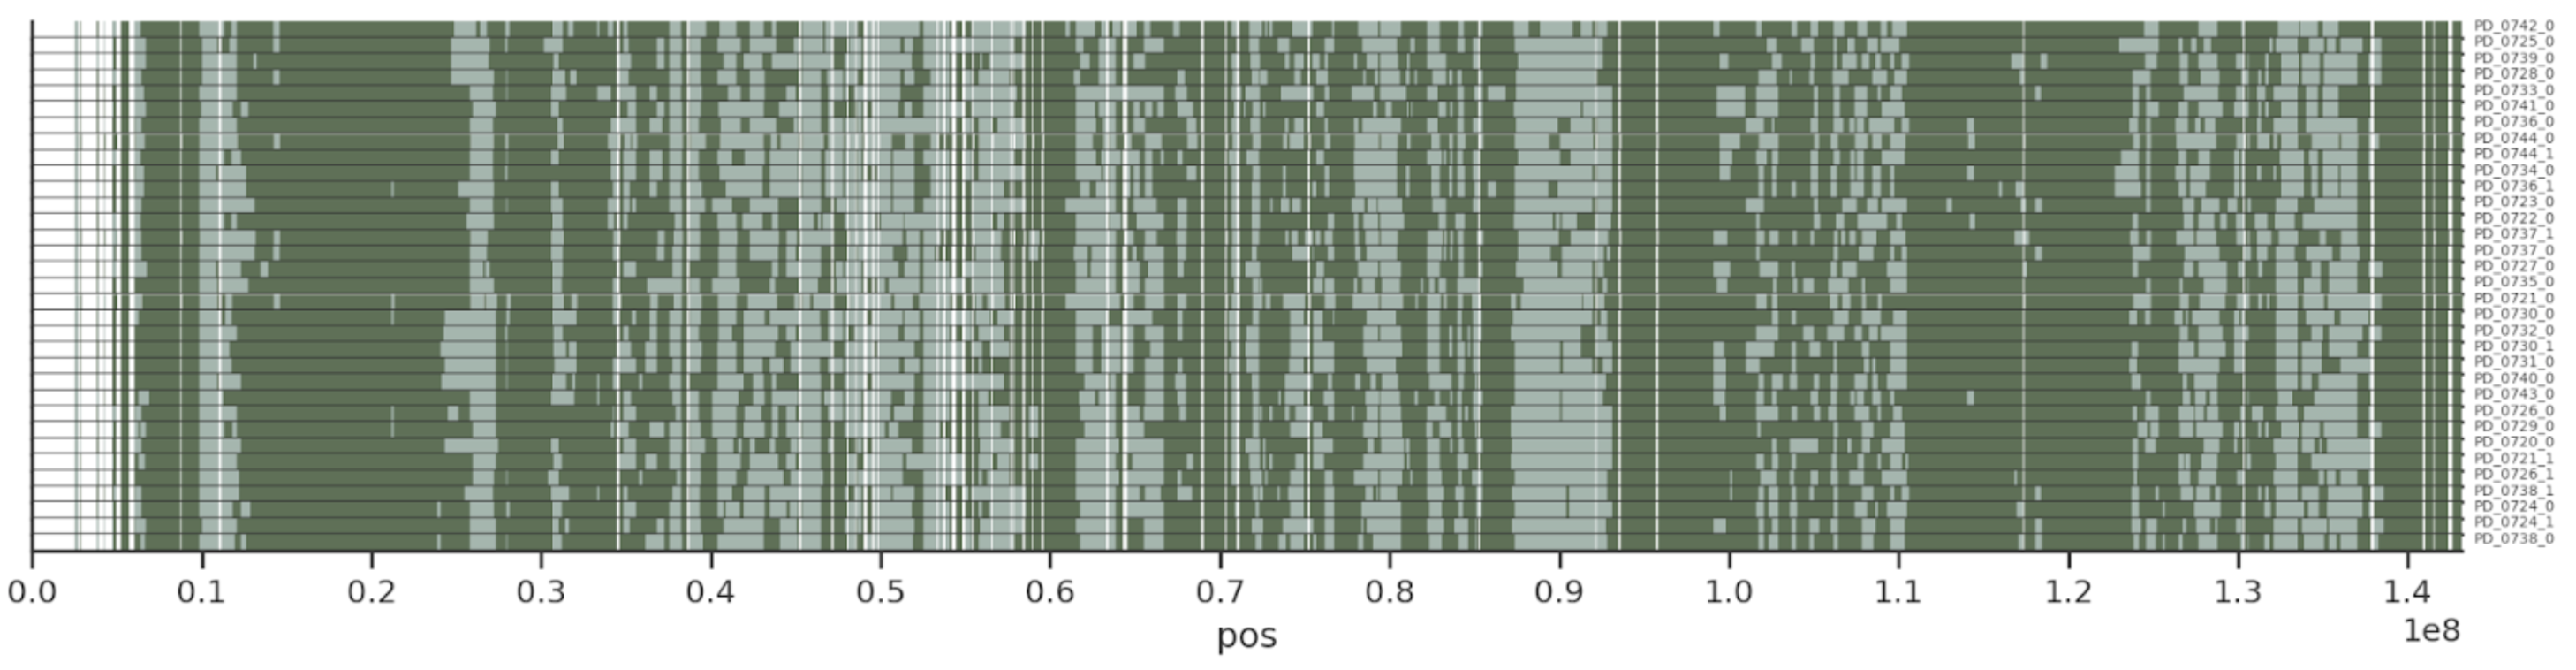

In [17]:
n = 20
a = 0.3
naa, nab, nbb = 10, 0, 10  

eaa, eab, ebb = n*a**2, n*2*a*(1-a), n*(1-a)**2
chisq_stat = ((naa - eaa)**2) / eaa + ((nab - eab)**2) / eab + ((nbb - ebb)**2) / ebb

from scipy.stats import chi2, chisquare
import numpy as np

n_obs = [naa, nab, nbb]
f_obs = [x/sum(n_obs) for x in n_obs]
n_exp = [eaa, eab, ebb]
f_exp = [x/sum(n_exp) for x in n_exp]
f_obs, f_exp, chisquare(f_obs, f_exp, ddof=1)

([0.5, 0.0, 0.5],
 [0.09000000000000001, 0.42, 0.49000000000000005],
 Power_divergenceResult(statistic=2.2879818594104306, pvalue=0.1303793534891013))

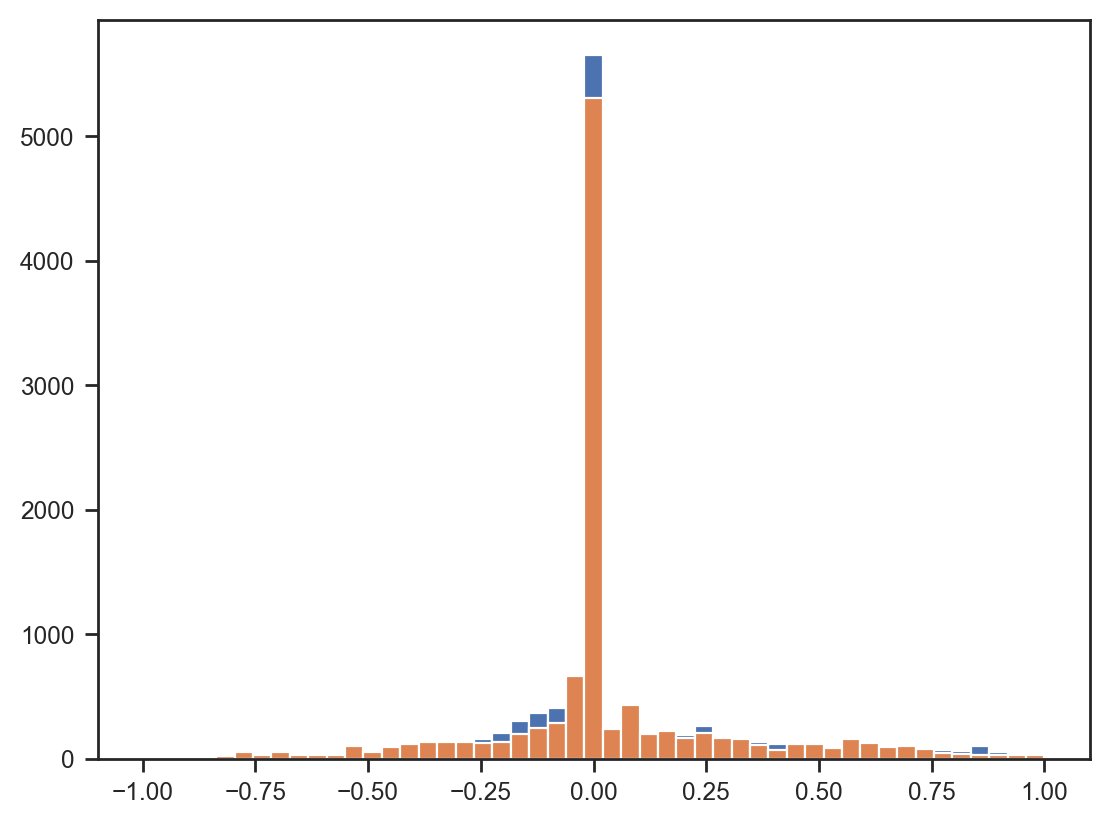

In [18]:
plt.hist(plot_df.homo_hama_excess, bins=np.linspace(-1, 1,50))
plt.hist(plot_df.homo_olive_excess, bins=np.linspace(-1, 1, 50)) ;

In [19]:
plot_df.groupby('start').mean()

TypeError: agg function failed [how->mean,dtype->object]

# If we stratify by window_mean_admix, is there then more homozygozity on x than 8?

(array([6874.,    0.,    0.,    0.,    0., 1259.,    0.,    0.,    0.,
        3058.]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000.]),
 <BarContainer object of 10 artists>)

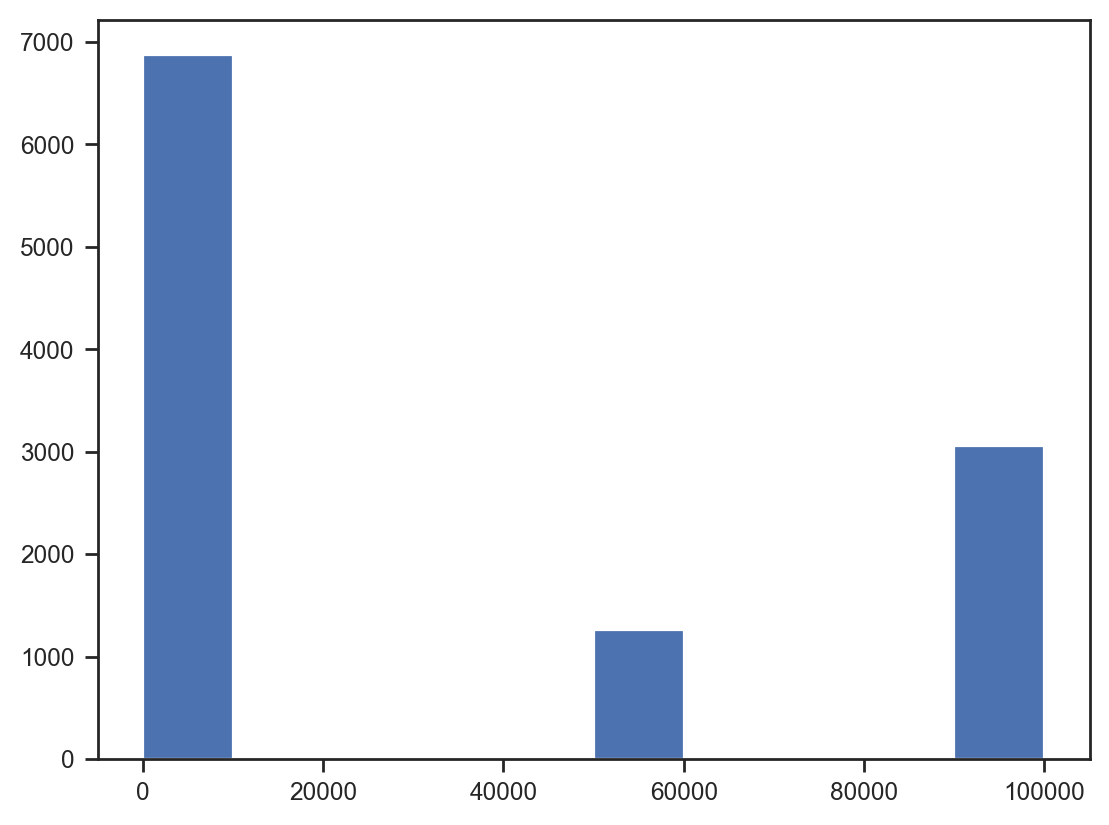

In [20]:
plt.hist(plot_df.north_sum)

In [21]:
pd.cut(plot_df.north_sum, [0, 1000, 99000, 100000], include_lowest=True).value_counts()

north_sum
(-0.001, 1000.0]       6874
(99000.0, 100000.0]    3058
(1000.0, 99000.0]      1259
Name: count, dtype: int64

In [22]:
pd.cut(plot_df.north_sum_window_mean, [0, 1000, 99000, 100000], include_lowest=True).value_counts()

north_sum_window_mean
(1000.0, 99000.0]      7129
(-0.001, 1000.0]       3759
(99000.0, 100000.0]     303
Name: count, dtype: int64

(array([4908.,  910.,  572.,  740.,  650.,  462.,  405.,  507.,  880.,
        1157.]),
 array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.,  90000., 100000.]),
 <BarContainer object of 10 artists>)

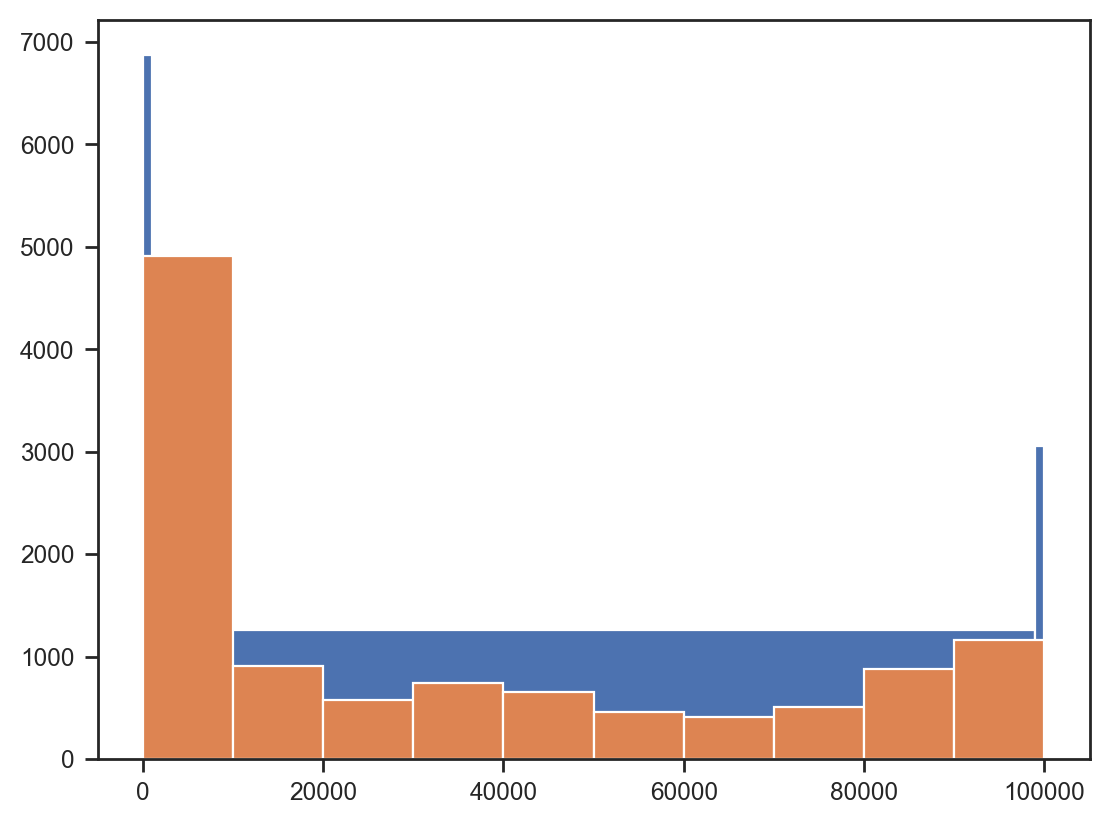

In [23]:
plt.hist(plot_df.north_sum, bins=[0, 1000, 99000, 100000]) ;
plt.hist(plot_df.north_sum_window_mean) 

In [24]:
#plot_df = window_df_eth.loc[window_df_eth.Sex == 'F'].groupby(["individual", "start"])[['north_sum', 'north_sum_window_mean']].mean()

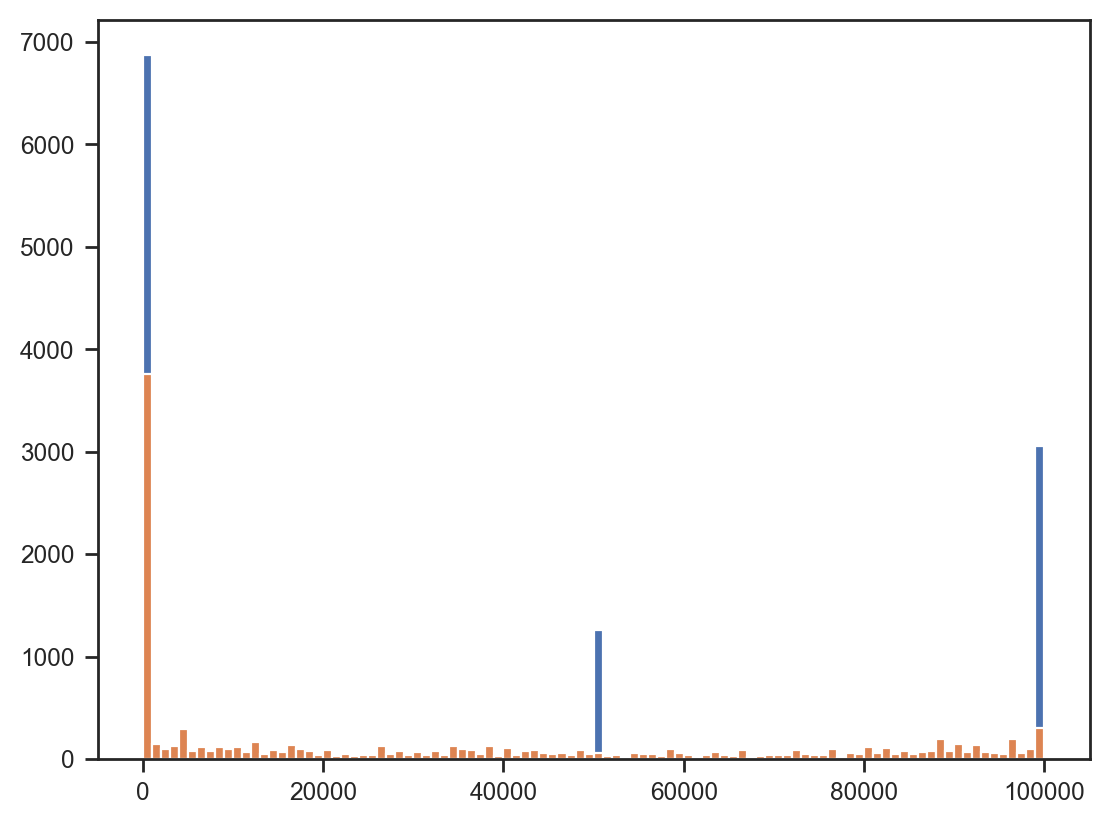

In [25]:
plt.hist(plot_df.north_sum, bins=100) ;
plt.hist(plot_df.north_sum_window_mean, bins=100) ;

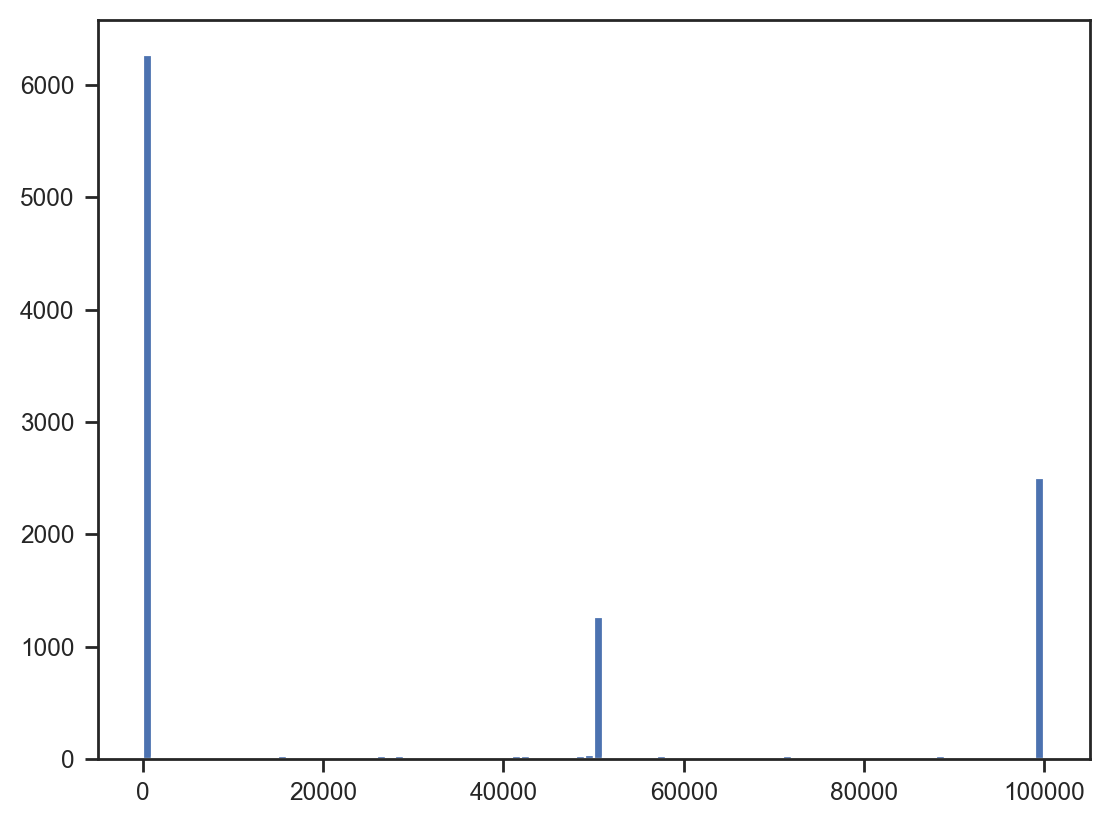

In [26]:
plt.hist(window_df_eth.loc[window_df_eth.Sex == 'F'].groupby(["individual", "start"]).north_sum.mean(), bins=100) ;
#plt.hist((window_df_eth.north_sum_window_mean / 100000)**2) ;

In [27]:
df = window_df_eth.groupby(["individual", "start"]).north_si.mean().reset_index()
#gog_x_data = mean_window_df_eth.loc[mean_window_df_eth.chrom == 'all_chrX']
df#.individual.unique()

AttributeError: 'DataFrameGroupBy' object has no attribute 'north_si'

In [57]:
window_df_eth.loc[window_df_eth.Sex == 'F'].groupby(["individual", "start"]).north_sum.mean()

individual  start    
PD_0721     0            0.0
            100000       0.0
            200000       0.0
            300000       0.0
            400000       0.0
                        ... 
PD_0744     143200000    0.0
            143300000    0.0
            143400000    0.0
            143500000    0.0
            143600000    0.0
Name: north_sum, Length: 11496, dtype: float64

(array([6.266e+03, 1.900e+01, 1.300e+01, 1.900e+01, 1.300e+01, 1.200e+01,
        1.200e+01, 2.000e+01, 1.400e+01, 1.200e+01, 5.000e+00, 1.300e+01,
        1.400e+01, 1.400e+01, 1.900e+01, 2.800e+01, 1.800e+01, 1.200e+01,
        1.400e+01, 1.300e+01, 1.500e+01, 1.300e+01, 1.500e+01, 1.000e+01,
        1.800e+01, 1.100e+01, 2.200e+01, 1.700e+01, 2.700e+01, 1.800e+01,
        2.100e+01, 8.000e+00, 9.000e+00, 9.000e+00, 1.800e+01, 8.000e+00,
        1.400e+01, 1.300e+01, 1.100e+01, 1.700e+01, 1.800e+01, 2.200e+01,
        2.200e+01, 1.300e+01, 1.300e+01, 8.000e+00, 1.400e+01, 1.700e+01,
        2.400e+01, 3.900e+01, 1.267e+03, 1.300e+01, 1.800e+01, 1.600e+01,
        1.800e+01, 6.000e+00, 9.000e+00, 2.500e+01, 1.300e+01, 1.100e+01,
        8.000e+00, 1.500e+01, 1.400e+01, 1.800e+01, 1.900e+01, 1.800e+01,
        9.000e+00, 1.400e+01, 2.100e+01, 2.000e+01, 1.200e+01, 2.500e+01,
        1.800e+01, 1.900e+01, 1.000e+01, 1.600e+01, 3.000e+00, 1.100e+01,
        1.800e+01, 1.600e+01, 1.300e+0

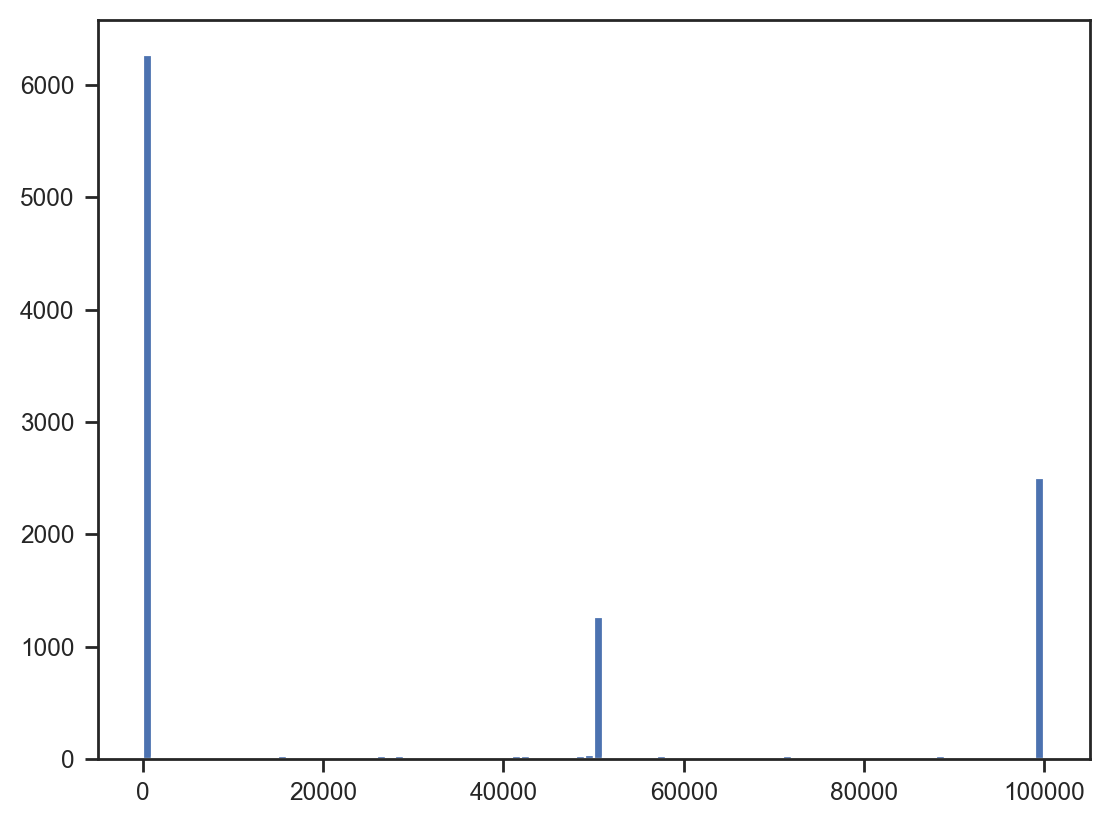

In [62]:
plt.hist(window_df_eth.loc[window_df_eth.Sex == 'F'].groupby(["individual", "start"]).north_sum.mean(), bins=100) 

In [68]:
#plt.hist(window_df_eth.loc[window_df_eth.Sex == 'M'].groupby(["individual", "start"]).north_sum.mean(), bins=100) ;

In [69]:
0.7**2 + 0.3**2, (6.266e+03 + 2.505e+03) / (6.266e+03 + 2.505e+03 + 1.267e+03)

(0.58, 0.8737796373779637)

In [72]:
0.3**2, (2.505e+03 / (6.266e+03 + 2.505e+03 + 1.267e+03))

(0.09, 0.24955170352659892)

In [73]:
0.7**2, (6.266e+03 / (6.266e+03 + 2.505e+03 + 1.267e+03))

(0.48999999999999994, 0.6242279338513648)

In [65]:
0.7**2 + 0.3**2

0.58